In [4]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import pandas as pd
from config import pickle_file
from tqdm import tqdm
import nltk
import collections
import numpy as np
import os
import librosa

In [5]:
with open(pickle_file, 'rb') as file:
    data = pickle.load(file)

In [6]:
keys = data.keys()
# 打印键列表
for key in keys:
    print(key)

VOCAB
IVOCAB
train
dev
test


In [7]:
print('训练集:'+str(len(data['train'])))
print('dev:'+str(len(data['dev'])))
print('test:'+str(len(data['test'])))
print('vocab_size:' + str(len(data['VOCAB'])))

训练集:120098
dev:14326
test:7176
vocab_size:4335


In [8]:
char_list = data['IVOCAB']
vocab_size = len(char_list)
samples = data['train']
bigram_counter = collections.Counter()

for sample in tqdm(samples):
    text = sample['trn']
    # text = [char_list[idx] for idx in text]
    tokens = list(text)
    bigrm = nltk.bigrams(tokens)
    bigram_counter.update(bigrm)
print(bigram_counter.most_common(10))

  0%|          | 0/120098 [00:00<?, ?it/s]

100%|██████████| 120098/120098 [00:01<00:00, 96863.26it/s]

[((24, 298), 4302), ((5, 146), 3791), ((147, 366), 3562), ((275, 356), 2870), ((356, 68), 2790), ((365, 70), 2729), ((365, 142), 2591), ((451, 183), 2547), ((65, 5), 2439), ((293, 133), 2376)]


In [9]:
print(char_list[24],char_list[298])
print(char_list[5],char_list[146])
print(char_list[147],char_list[366])

中 国
市 场
公 司


In [10]:
# temp_dict = dict()
# for key, value in bigram_counter.items():
#     temp_dict[key] = value

# print('smoothing and freq -> prob')
# bigram_freq = dict()
# # 整个的字符表
# for i in tqdm(range(vocab_size)):
#     freq_list = []
#     for j in range(vocab_size):
#         if (i, j) in temp_dict:
#             freq_list.append(temp_dict[(i, j)])
#         else:
#             # 保证每个字符对至少一次
#             freq_list.append(1)

#     freq_list = np.array(freq_list)
#     freq_list = freq_list / np.sum(freq_list)

#     assert (len(freq_list) == vocab_size)
#     bigram_freq[i] = freq_list

# print(len(bigram_freq[0]))
# with open('bigram_freq.pkl', 'wb') as file:
#     pickle.dump(bigram_freq, file)

In [11]:
print(char_list[1])

<eos>


In [12]:
# print(bigram_freq[1][1])

In [13]:
max_input_len = float('-inf')
max_target_len = float('-inf')

In [14]:
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

In [15]:
audio_path = os.path.join("../dataset/data_aishell/wav/train/S0002/BAC009S0002W0122.wav")
sr, audio = wavfile.read(audio_path)

x = librosa.feature.melspectrogram(y=audio.astype(float), sr=sr, S=None, n_fft=512, hop_length=256, n_mels=40).T
x = librosa.power_to_db(x, ref=np.max)

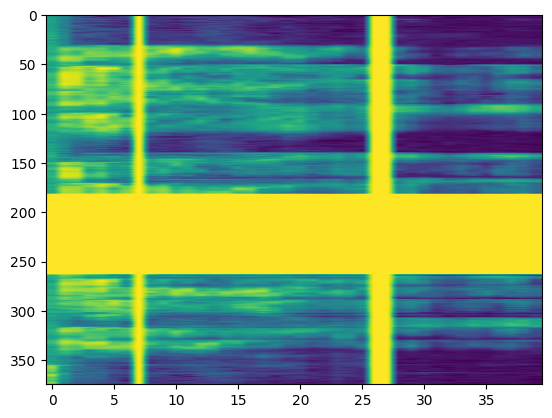

In [16]:
plt.figure()
plt.imshow(spec_augment(x),aspect= 'auto')
plt.show()

In [17]:
# 抽帧
def build_LFR_features(inputs, m, n):
    """
    Actually, this implements stacking frames and skipping frames.
    if m = 1 and n = 1, just return the origin features.
    if m = 1 and n > 1, it works like skipping.
    if m > 1 and n = 1, it works like stacking but only support right frames.
    if m > 1 and n > 1, it works like LFR.
    Args:
        inputs_batch: inputs is T x D np.ndarray
        m: number of frames to stack
        n: number of frames to skip
    """
    # LFR_inputs_batch = []
    # for inputs in inputs_batch:
    LFR_inputs = []
    T = inputs.shape[0]
    T_lfr = int(np.ceil(T / n))
    for i in range(T_lfr):
        if m <= T - i * n:
            LFR_inputs.append(np.hstack(inputs[i * n:i * n + m]))
        else:  # process last LFR frame
            num_padding = m - (T - i * n)
            frame = np.hstack(inputs[i * n:])
            for _ in range(num_padding):
                frame = np.hstack((frame, inputs[-1]))
            LFR_inputs.append(frame)
    return np.vstack(LFR_inputs)

In [18]:
audio_path = os.path.join("../dataset/data_aishell/wav/train/S0002/BAC009S0002W0122.wav")
sr, audio = wavfile.read(audio_path)

x = librosa.feature.melspectrogram(y=audio.astype(float), sr=sr, S=None, n_fft=512, hop_length=256, n_mels=40).T
x = librosa.power_to_db(x, ref=np.max)

In [19]:
feature1 = spec_augment(x)
# 明显看出n的作用
feature = build_LFR_features(feature1, m=1, n=10)

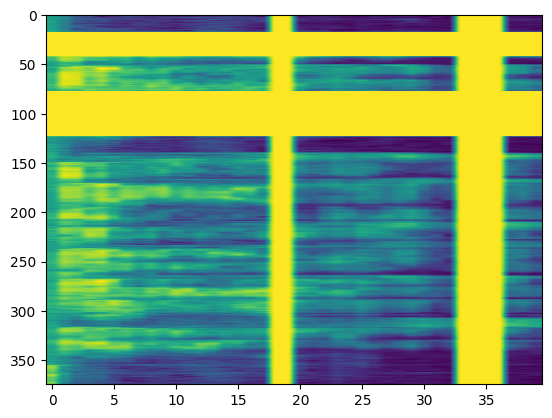

In [20]:
plt.figure()
plt.imshow(feature1,aspect= 'auto')
plt.show()

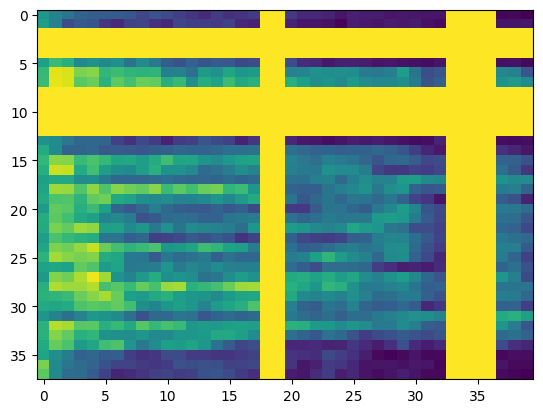

In [21]:
plt.figure()
plt.imshow(feature,aspect= 'auto')
plt.show()

In [22]:
# 测试data——process
from torch.utils.data import DataLoader
import data_process
dataset=data_process.AiShellDataset('test')
first_data = dataset[0]
feature,trn=first_data

In [23]:
print(feature,trn)

[[-0.3262395   0.17098634  0.31233305 ... -0.7408709  -0.7317126
  -0.63851285]
 [ 0.17852771  0.13855937 -0.3834093  ... -0.685384   -0.6265054
  -0.6549062 ]
 [ 0.4784395  -0.08476716 -0.9655915  ... -0.73383915 -0.6200245
  -0.59371793]
 ...
 [ 1.4995568   1.59078     1.3565599  ... -0.8034648  -0.8160007
  -0.6473056 ]
 [ 0.35263103 -0.22914332 -0.19947994 ... -0.89558774 -0.7786102
  -0.6196669 ]
 [ 1.4995587   1.4148687   0.07129297 ... -0.8218369  -0.80060863
  -0.66357666]] [1041, 1034, 90, 372, 7, 643, 1038, 1039, 699, 1460, 14, 272, 1098, 1]


In [24]:
for i in trn:
    print(char_list[i],end="")

甚至出现交易几乎停滞的情况<eos>

In [25]:
data['test'][0]

{'trn': [1041, 1034, 90, 372, 7, 643, 1038, 1039, 699, 1460, 14, 272, 1098, 1],
 'wave': '../dataset/data_aishell/wav\\test\\S0764\\BAC009S0764W0121.wav'}

In [26]:
from padding import pad_collate
dataloader=DataLoader(dataset, batch_size=32, collate_fn=pad_collate,
                                               pin_memory=True, shuffle=True, num_workers=4)

In [30]:
datatiter=iter(dataloader)
data=next(datatiter)
features=data
print(features)

[tensor([[[-0.2627,  4.3600,  1.2547,  ..., -0.9078, -0.8719, -0.6765],
         [ 0.2183,  0.3541,  0.3901,  ..., -0.5421, -0.0953,  0.2831],
         [ 0.2948,  0.2666,  0.7901,  ..., -0.3266,  0.3430,  0.5880],
         ...,
         [ 1.8276,  2.3562, -0.0525,  ..., -0.9397, -0.9328, -0.7565],
         [-0.3190, -0.0090, -0.2249,  ..., -0.9455, -0.9369, -0.7566],
         [ 1.5035,  1.6643, -0.8592,  ...,  0.1363,  0.2758,  1.0806]],

        [[-0.0234,  0.4137, -0.3948,  ..., -1.1741, -1.0405, -0.8038],
         [-0.6177, -1.0561, -1.4357,  ..., -1.0853, -1.0568, -0.8278],
         [ 0.5272, -0.0761, -0.0966,  ..., -0.8703, -0.9005, -0.7557],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.2827,  2.3723,  0.9484,  ...,  1.0321,  1.3014,  1.6432],
         [-1.5282, -1.2367, -0.7570,  ...,  